# Fourier Series Approximation

The goal of this notebook is to compute the Fourier Series approximation of a function f(x). As a reminder, for some function f(x), the Fourier Series approxmiation is:

$$
f(x) = \frac{A_0}{2} + \sum_{k=1}^{\infty} A_k \cdot \cos(\frac{2 \pi k x}{L}) + B_k \cdot \sin(\frac{2 \pi k x}{L}) \\
A_k = \langle f(x), \cos(\frac{2 \pi k x}{L}) \rangle  = \frac{2}{L} \int_{0}^L f(x) \cdot \cos(\frac{2 \pi k x}{L}) dx \\
B_k = \langle f(x), \sin(\frac{2 \pi k x}{L}) \rangle = \frac{2}{L} \int_{0}^L f(x) \cdot \sin(\frac{2 \pi k x}{L}) dx
$$

Intuitively speaking, we are using the fact that $\cos$ and $\sin$ form an orthonormal basis for periodic functions on a defined interval to calculate how much of the basis is present $f(x)$ and then summing those components up to compute the approximation. It's almost like you have some set of basis vectors, and to compute a particular vector in the vector space you sum some coefficient * basis vector to form the vector.


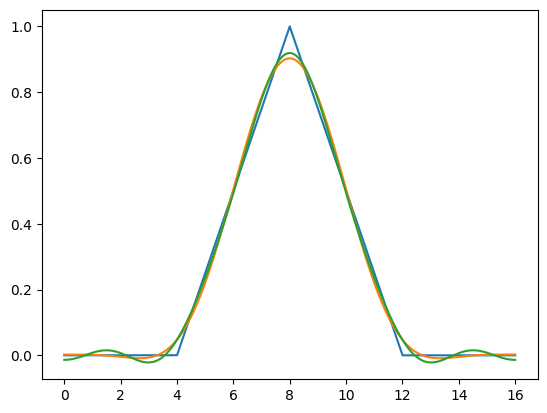

In [ ]:
# Overall Plan:
# - Define the hat function
# - Iterate through n iterations
# -- Compute the coefficients
# -- Compute the Fourier Series
# - Plot the hat function, and all n iterations of the Fourier approximation

import numpy as np
import matplotlib.pyplot as plt

L = 16
dx = 1e-3 # spacing
num_samples = int(L/dx)
x = np.linspace(0, L, num_samples) 

def f(x: np.ndarray, L: float) -> np.ndarray:
    output = np.zeros_like(x)
    rising_mask = (x >= L/4) & (x < L/2) 
    falling_mask = (x >= L/2) & (x < 3*L/4)
    # These were analytically calculated via y = mx + c
    output[rising_mask] = (4/L) * x[rising_mask] - 1
    output[falling_mask] = 3 - (4*x[falling_mask]/L)
    return output


def fourier_series_approximation(x: np.ndarray, f_values: np.ndarray, iterations: int, L: int, dx: float) -> np.ndarray:
    approximation = np.zeros_like(x)

    # Implement a vectorized coefficient calculation
    k = np.arange(1, iterations+1, 1)
    X, K = np.meshgrid(x, k)
    A_arr = np.sum(np.cos((2 * np.pi * X * K) / L) * f_values * dx * (2/L), axis=1)
    B_arr = np.sum(np.sin((2 * np.pi * X * K) / L) * f_values * dx * (2/L), axis=1)

    def A_k(k: int):
        return np.sum(np.cos(2*np.pi*k*x*(1/L)) * f_values * dx) * (2/L)
    
    # def B_k(k: int):
    #     return np.sum(np.sin(2*np.pi*k*x*(1/L)) * f_values * dx) * (2/L)

    A_0 = A_k(0) / 2
    for i in range(1, iterations+1): # Include the last iteration
        A = A_arr[i-1]
        B = B_arr[i-1]
        k_approximation = A * np.cos(2*np.pi*i*x*(1/L)) + B * np.sin(2*np.pi*i*x*(1/L))
        approximation += k_approximation

    return A_0 + approximation 


output = f(x, L)

three_approx = fourier_series_approximation(x, output, 3, L, dx)
five_approx = fourier_series_approximation(x, output, 5, L, dx)
plt.figure()
plt.plot(x, output, '-')
plt.plot(x, three_approx, '-')
plt.plot(x, five_approx, '-')
plt.show()





In [59]:
x = np.arange(10, 20, 1)
k = np.arange(0, 10, 1)
print(x)
X, K = np.meshgrid(x, k)
print(np.sum(np.cos((2 * np.pi * X * K) / L), axis=1))

[10 11 12 13 14 15 16 17 18 19]
[10.          3.93754928 -0.70710678  0.13438055 -1.          0.45140589
  0.70710678 -0.52333572  0.         -0.52333572]
